# Exercise 4

In [1]:
# Done by Timo Marks and Munther Odeh
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import mnist
subplot_keywords = {"xticks": [0,27], "yticks": [0,27]}

# from functions import *

### Basic Functions

In [2]:
def MnistRead():
    train_images = mnist.train_images()
    train_labels = mnist.train_labels()

    test_images = mnist.test_images()
    test_labels = mnist.test_labels()

    print('train_images: ' + str(train_images.shape))
    print('train_labels: ' + str(train_labels.shape))
    print('test_images:  '  + str(test_images.shape))
    print('test_labels:  '  + str(test_labels.shape))
    return [train_images, train_labels, test_images, test_labels]

# Creates num_grid * num_grid subplot of images
def MnistShow(images, num_grid = 4):
    plt.set_cmap("gray")
    fig, ax = plt.subplots(num_grid, num_grid, figsize=(10,10), sharex=True, sharey=True, subplot_kw = subplot_keywords)
    for i in range(num_grid):
        for j in range(num_grid):
            ax[i,j].imshow(images[i*num_grid+j])
    plt.show()
    
# Create a feature vector of each image
def matrix2vector(images):
    images = images.reshape(images.shape[0], (images.shape[1] * images.shape[2]))
    return np.transpose(images)

# Inverse transformation of feature vector in image
def vector2matrix(feature_vector, NCol, NRow):
    # return feature_vector.reshape((feature_vector.shape[0], NCol, NRow))
    feature_vector = np.transpose(feature_vector)
    return feature_vector.reshape((feature_vector.shape[0], NCol, NRow))


### 1. Read in Data and Visualization

train_images: (60000, 28, 28)
train_labels: (60000,)
test_images:  (10000, 28, 28)
test_labels:  (10000,)


<Figure size 432x288 with 0 Axes>

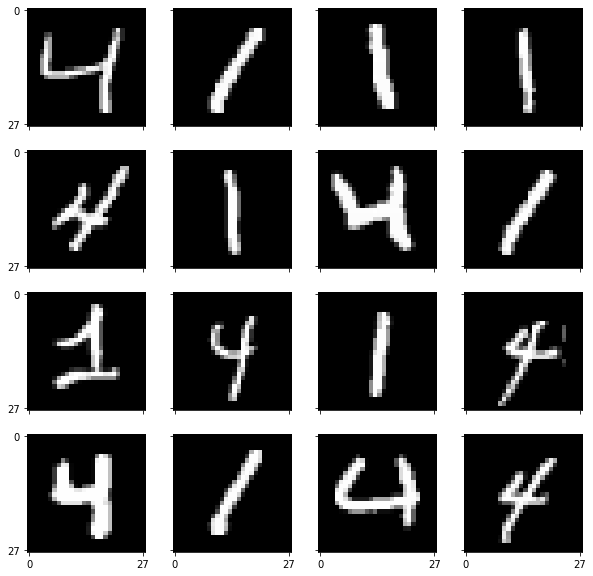

<Figure size 432x288 with 0 Axes>

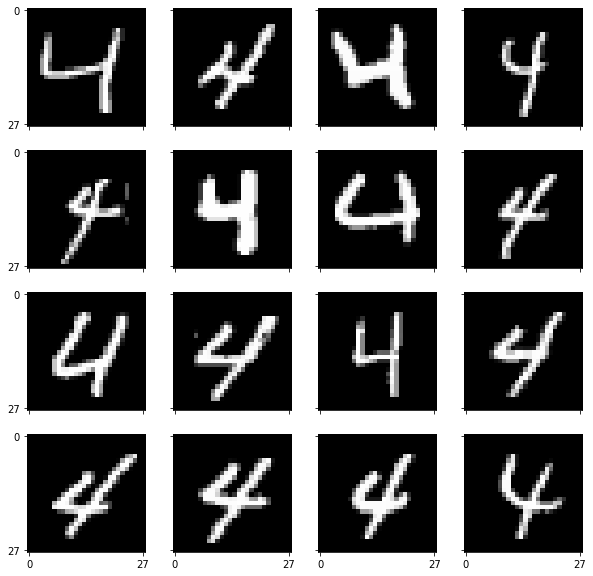

In [3]:
[train_images, train_labels, test_images, test_labels] = MnistRead()

# Pick out specific numbers
digit_A = 1
digit_B = 4

# Array containing both numbers
train_labels_mask = np.asarray(train_labels[:] == digit_A) | np.asarray(train_labels[:] == digit_B)
train_images, train_labels = train_images[train_labels_mask,:,:], train_labels[train_labels_mask]

test_labels_mask = np.asarray(test_labels[:] == digit_A) | np.asarray(test_labels[:] == digit_B)
test_images, test_labels = test_images[test_labels_mask,:,:], test_labels[test_labels_mask]

# Array containing only the specific numbers
train_images_digit_A = train_images[train_labels[:] == digit_A,:,:]
train_labels_digit_A = train_labels[train_labels[:] == digit_A]

train_images_digit_B = train_images[train_labels[:] == digit_B,:,:]
train_labels_digit_B = train_labels[train_labels[:] == digit_B]

test_images_digit_A = test_images[test_labels[:] == digit_A,:,:]
train_labels_digit_A = test_labels[test_labels[:] == digit_A]

test_images_digit_B = test_images[test_labels[:] == digit_B,:,:]
test_labels_digit_B = test_labels[test_labels[:] == digit_B]

MnistShow(train_images) # Both digits
MnistShow(train_images_digit_B) # Digit_B got sorted out

### Testing: Transformation of image to feature vector and backwards
If this fails, the upcoming calculation are not correct. Make sure the images are the same

Text(0.5, 1.0, 'Inverse transformation of transformed\nimage. Should be the same.')

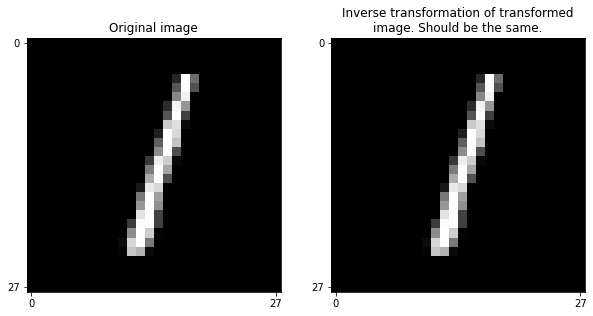

In [4]:
(NFrame, NRow, NCol) = test_images.shape
feature_vectors = matrix2vector(test_images)
images = vector2matrix(feature_vectors, NRow, NCol)

fig, ax = plt.subplots(1,2, figsize=(10,5), subplot_kw=subplot_keywords)
ax[0].imshow(test_images[0])
ax[1].imshow(images[0])
ax[0].set_title("Original image")
ax[1].set_title("Inverse transformation of transformed\nimage. Should be the same.")

### 5. Perform linear discriminant analysis

In [5]:
def learn_lda(mat_X_digitA, mat_X_digitB, mat_X_digit, weights_filename = "vec_w_opt_lda", vec_y_filename = "vec_y_lda"):
    n_1 = mat_X_digitA.shape[1]
    m_1 = 1.0/n_1 * np.sum(mat_X_digitA, axis=1)
    m_1 = m_1.reshape(m_1.shape[0],1)
    
    # Create matrix of ones, so we artificially copy m_1 to new columns for a matrix 
    # This is helpful for mat_X_digitA - m_1
    ones = np.ones(mat_X_digitA.shape[1]).reshape(1, mat_X_digitA.shape[1])
    m_1_mat = np.matmul(m_1, ones)
    print(f"Step 1 / 5: Shape m_1_mat: {m_1_mat.shape} Shape mat_X_digitA: {mat_X_digitA.shape}")
    S_1 = np.matmul((mat_X_digitA-m_1_mat), np.transpose(mat_X_digitA-m_1_mat))

    # Same for digit B
    n_2 = mat_X_digitB.shape[1]
    m_2 = 1.0/n_2 * np.sum(mat_X_digitB, axis=1)
    m_2 = m_2.reshape(m_2.shape[0],1)
    
    ones = np.ones(mat_X_digitB.shape[1]).reshape(1, mat_X_digitB.shape[1])
    m_2_mat = np.matmul(m_2, ones)
    print(f"Step 2 / 5: Shape m_2_mat: {m_2_mat.shape} Shape mat_X_digitB: {mat_X_digitB.shape}")
    S_2 = np.matmul((mat_X_digitB-m_2_mat), np.transpose(mat_X_digitB-m_2_mat))
    
    S_W = S_1 + S_2
    print(f"Step 3 / 5: Shape S_W: {S_W.shape}")
    
    S_W_inv = np.linalg.pinv(S_W) # Use Moore-Penrose pseudo-inverse of a matrix
    vec_w_opt_lda = np.matmul(S_W_inv, (m_1 - m_2))
    print(f"Step 4 / 5: Shape vec_w_opt_lda: {vec_w_opt_lda.shape}")

    vec_y_lda = compute_output_vec_y(vec_w_opt_lda, mat_X_digit)
    print(f"Step 5 / 5: Shape vec_y_lda: {vec_y_lda.shape}")
    return [vec_w_opt_lda, vec_y_lda, m_1, m_2]

def compute_output_vec_y (vec_w_opt_lda, mat_X):
    return np.matmul(np.transpose(vec_w_opt_lda), mat_X)

def predict_one_y (vec_w_opt_lda, x, digit_A, digit_B):
    vec_y_lda = compute_output_vec_y(vec_w_opt_lda, x)
    if vec_y_lda > 0: 
        return digit_A
    else:
        return digit_B

Step 1 / 5: Shape m_1_mat: (784, 6742) Shape mat_X_digitA: (784, 6742)
Step 2 / 5: Shape m_2_mat: (784, 5842) Shape mat_X_digitB: (784, 5842)
Step 3 / 5: Shape S_W: (784, 784)
Step 4 / 5: Shape vec_w_opt_lda: (784, 1)
Step 5 / 5: Shape vec_y_lda: (1, 12584)


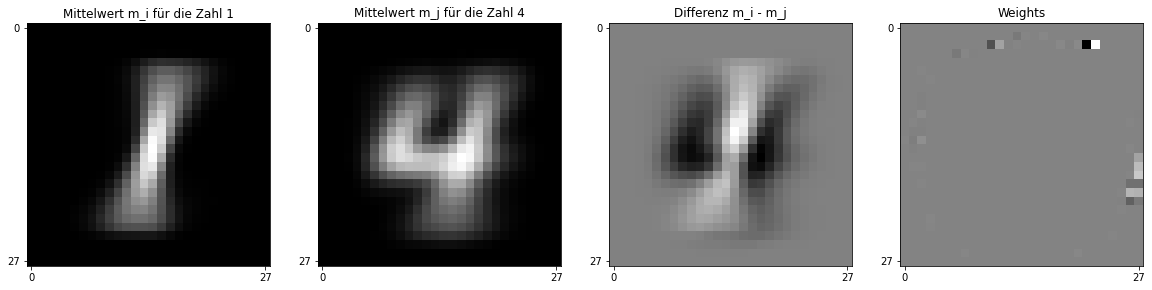

In [6]:
(NFrame, NRow, NCol) = train_images_digit_A.shape
[vec_w_opt_lda, vec_y_lda, m_1, m_2] = learn_lda(matrix2vector(train_images_digit_A), matrix2vector(train_images_digit_B), matrix2vector(train_images))

mat_weights = vec_w_opt_lda.reshape(NRow, NCol)
fig, ax = plt.subplots(1,4,figsize=(20,5), subplot_kw=subplot_keywords)
ax[0].imshow(m_1.reshape(NRow, NCol))
ax[0].set_title(f"Mittelwert m_i für die Zahl {digit_A}")

ax[1].imshow(m_2.reshape(NRow, NCol))
ax[1].set_title(f"Mittelwert m_j für die Zahl {digit_B}")

ax[2].imshow((m_1-m_2).reshape(NRow, NCol))
ax[2].set_title(f"Differenz m_i - m_j")

ax[3].imshow(vec_w_opt_lda.reshape(NRow, NCol))
ax[3].set_title(f"Weights")

plt.show()

### 6 Model Accuracy
The method gives a high accuracy around 97%-99% even when the test data set is used. The Accuracy depends on the used numbers. Numbers which are more similar have a smaller pair accuracy. 

In [7]:
def compute_accuracy(vec_y_lda, vec_y_true, digit_A, digit_B):
    vec = (np.zeros(vec_y_lda.shape[1]))
    vec_y_lda = vec_y_lda.flatten()
    vec[vec_y_lda[:] > 0] = digit_A
    vec[vec_y_lda[:] <= 0] = digit_B
    vec_true_false = vec[vec == vec_y_true]

    return len(vec_true_false)/len(vec_y_true)

In [8]:
vec_y_lda = compute_output_vec_y(vec_w_opt_lda, matrix2vector(train_images))
accuracy = compute_accuracy(vec_y_lda, train_labels, digit_A, digit_B)
print(f"Train data: The Accuracy of the model with digit A: {digit_A} and digit B: {digit_B} is: {accuracy:.5f}")

vec_y_lda = compute_output_vec_y(vec_w_opt_lda, matrix2vector(test_images))
accuracy = compute_accuracy(vec_y_lda, test_labels, digit_A, digit_B)
print(f"Test data:  The Accuracy of the model with digit A: {digit_A} and digit B: {digit_B} is: {accuracy:.5f}")

Train data: The Accuracy of the model with digit A: 1 and digit B: 4 is: 0.99213
Test data:  The Accuracy of the model with digit A: 1 and digit B: 4 is: 0.98725


### 7. Test model with test dataset and show the classification

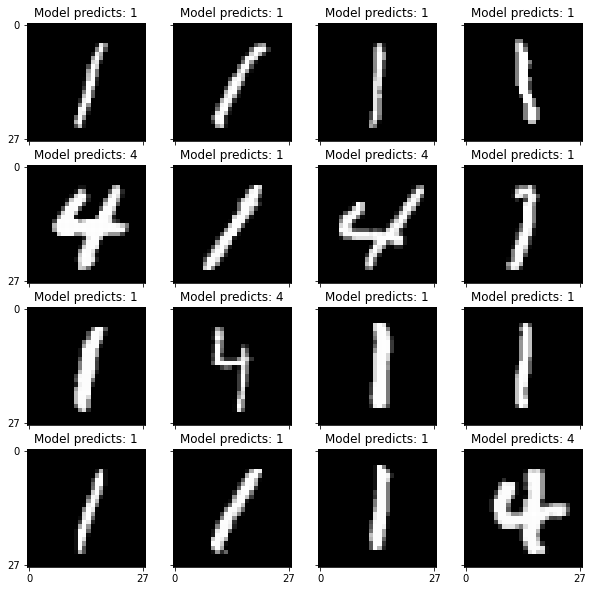

In [9]:
mat_weights = vec_w_opt_lda.reshape(NRow, NCol)

num_grid = 4
fig, ax = plt.subplots(num_grid, num_grid, figsize=(10,10), subplot_kw=subplot_keywords, sharex=True, sharey=True)

# Take some random examples from the test dataset and show the prediction
train_images_digit_A_vec, train_images_digit_B_vec = matrix2vector(train_images_digit_A), matrix2vector(train_images_digit_B)
Test1, Test2, Test3 = train_images_digit_A_vec[:,3], train_images_digit_A_vec[:,600], train_images_digit_B_vec[:,600]

test_images_vec = matrix2vector(test_images)
for i in np.arange(num_grid):
    for j in np.arange(num_grid):
    # Take some random examples from the test dataset and show the prediction
        max_int = test_images_vec.shape[1]
        rand = np.random.randint(0, max_int)
        Example_data = test_images_vec[:,rand]
        prediction = predict_one_y(vec_w_opt_lda, Example_data, digit_A, digit_B)
        ax[i,j].imshow(Example_data.reshape(NRow, NCol))
        ax[i,j].set_title(f"Model predicts: {prediction}")
plt.show()